## Data Loading

In [32]:
# Imports
import torch
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data import random_split
import numpy as np

In [33]:
dataset = MNIST(root="data/", download=True, transform=ToTensor())

In [34]:
val_size = 10_000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset=dataset,
                                lengths=[train_size, val_size])

In [35]:
batch_size = 128

In [36]:
from torch.utils.data import DataLoader

In [37]:
train_loader = DataLoader(dataset=train_ds,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(dataset=val_ds,
                        batch_size=batch_size,
                        shuffle=True)

torch.Size([128, 1, 28, 28])


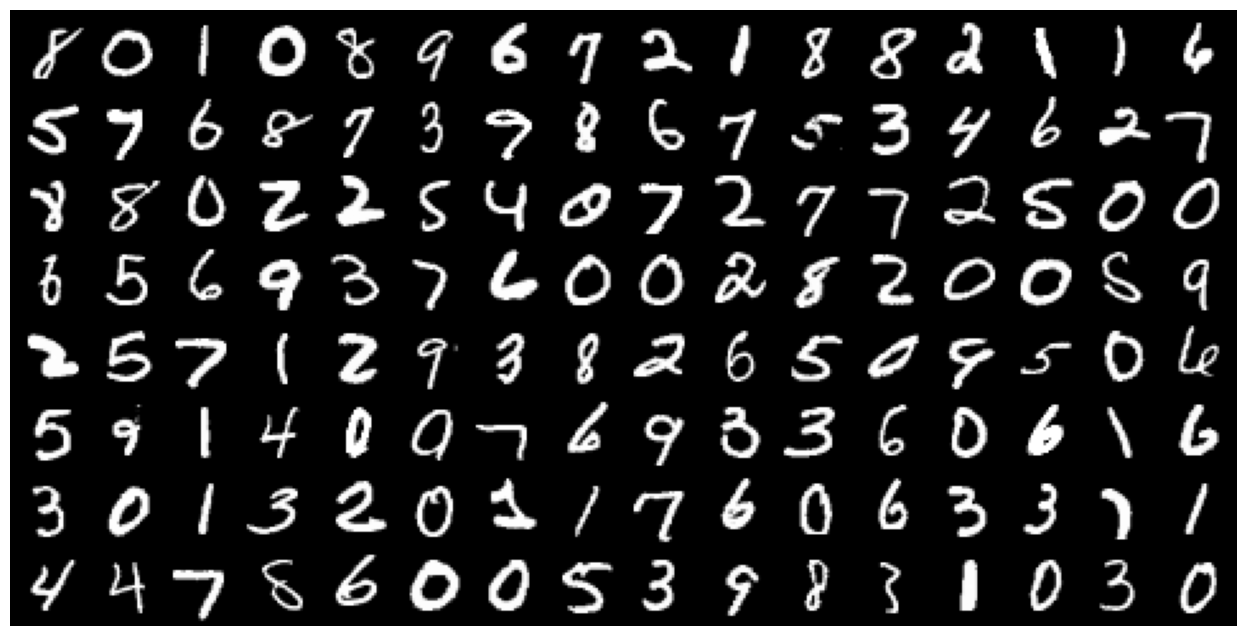

In [38]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, _ in train_loader:
    print(images.size())
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Going Deep (To N Layers!)

We are now ready to define our model. We'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Let's define the model by extending the `nn.Module` class from PyTorch.

In [39]:
import torch.nn as nn
import torch.nn.functional as F


class MNISTModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.activation_fn = F.relu
        self.loss_fn = F.cross_entropy

    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        output_1 = self.linear1(xb)
        activated_output = self.activation_fn(output_1)
        output = self.linear2(activated_output)
        return output
    
    def training_step(self, batch):
        images, labels = batch
        preds = self(images)
        loss =  self.loss_fn(preds, labels)
        return loss

In [40]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [44]:
optimizer = torch.optim.SGD

def fit(num_epochs:int, lr:float, train_loader:DataLoader, val_loader:DataLoader, model:MNISTModel):

    optim = optimizer(params=model.parameters(), lr=lr)

    loss_val = []
    acc_val = []
    for epoch in range(num_epochs):
        for batch in train_loader:
            loss = model.training_step(batch=batch)
            loss.backward()
            optim.step()
            optim.zero_grad()

        
        for xb_val, yb_val in val_loader:
            preds_val = model.forward(xb_val)
            loss_val.append(F.cross_entropy(preds_val, yb_val))
            acc_val.append(accuracy(preds_val, yb_val))
        
        print(f"Iteration {epoch + 1} Epoch Val Loss ====> {torch.stack(loss_val).mean()}; Val Accuracy ===> {torch.stack(acc_val).mean()}")
    

In [45]:
digit_model = MNISTModel(input_size=784,
                         hidden_size=32,
                         output_size=10)

In [97]:
fit(num_epochs=10, lr=0.5, train_loader=train_loader, val_loader=val_loader, model=digit_model)

Iteration 1 Epoch Val Loss ====> 0.22352729737758636; Val Accuracy ===> 0.9330498576164246
Iteration 2 Epoch Val Loss ====> 0.2160121649503708; Val Accuracy ===> 0.9340387582778931
Iteration 3 Epoch Val Loss ====> 0.19898399710655212; Val Accuracy ===> 0.940796434879303
Iteration 4 Epoch Val Loss ====> 0.1843569278717041; Val Accuracy ===> 0.9452877640724182
Iteration 5 Epoch Val Loss ====> 0.1760789155960083; Val Accuracy ===> 0.947765052318573
Iteration 6 Epoch Val Loss ====> 0.1680641919374466; Val Accuracy ===> 0.9500923156738281
Iteration 7 Epoch Val Loss ====> 0.16272784769535065; Val Accuracy ===> 0.9520089030265808
Iteration 8 Epoch Val Loss ====> 0.16136913001537323; Val Accuracy ===> 0.9527665376663208
Iteration 9 Epoch Val Loss ====> 0.15702511370182037; Val Accuracy ===> 0.9540260434150696
Iteration 10 Epoch Val Loss ====> 0.15421675145626068; Val Accuracy ===> 0.9550336003303528


In [ ]:
list(digit_model.parameters())

In [49]:
test_ds = MNIST(root="data/", train=False, transform=ToTensor())

In [52]:
test_loader = DataLoader(dataset=test_ds)

In [93]:
def predict_random_image(image, model):
    plt.imshow(image[0], cmap='gray')
    x = image.unsqueeze(0) # to set batch size * channel * height * width => 1*1*28*28
    y = model(x)
    return y
    

tensor([[ 0.7661, -2.6077, -0.4281,  8.4155, -5.3618,  2.6548, -7.5539,  0.1768,
          2.0243, -0.5719]], grad_fn=<AddmmBackward0>)

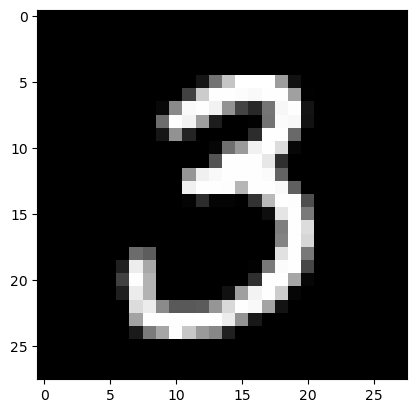

In [94]:
predict_random_image(test_ds[90][0], digit_model)

In [95]:
test_ds[90][1]

3

tensor(1.)

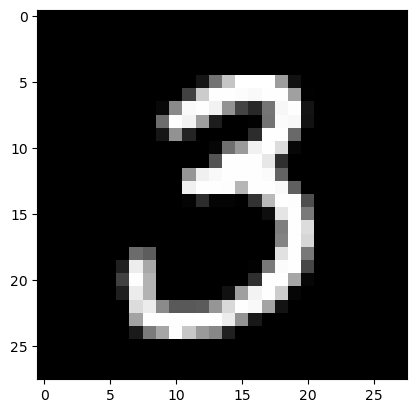

In [96]:
x = predict_random_image(test_ds[90][0], digit_model)
accuracy(x, test_ds[90][1])